In [5]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Выводим корреляционную матрицу
def show_correlation_map(df):
    cor = df.corr()
    plt.figure(figsize=(16,9))
    sns.heatmap(cor, center=0, cmap="RdYlGn", annot = True)
    plt.show()

Загружаем случайный датасет и вычисляем точность с помощью cross_val_score

In [24]:
x_data_generated, y_data_generated = make_classification(scale=1)
df = pd.DataFrame(x_data_generated)
df['target'] = y_data_generated
accuracies = {}

accuracy = cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='accuracy').mean()
print("First accuracy:", accuracy)
accuracies["First"] = accuracy 

First accuracy: 0.86


Выведем матрицу корреляции для отбора параметров, которые имеют большее влияние на модель

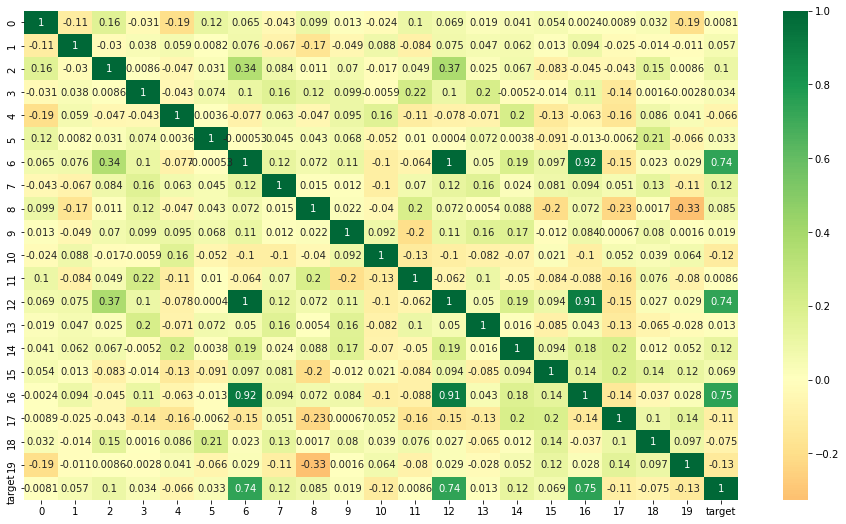

In [25]:
show_correlation_map(pd.DataFrame(df))

Удалим параметры имеющие корреляцию близкую к нулю и посчитаем точность модели

In [26]:
corr_df = df.drop(df.iloc[:, [0,1,3,4,5,9,11,13,15,18]],axis = 1)
X = corr_df.loc[:, corr_df.columns != 'target']
Y = corr_df['target']
accuracy = cross_val_score(LogisticRegression(), X, Y, scoring='accuracy').mean()
print("Selected params by correlation accuracy:", accuracy)
accuracies["Correlation"] = accuracy 

Selected params by correlation accuracy: 0.8799999999999999


Используем VarianceThreshold для отбора параметров, вычисляем точность

In [27]:
selector = VarianceThreshold()
var_threshold_df = pd.DataFrame(selector.fit_transform(df))
var_threshold_df.columns = [*var_threshold_df.columns[:-1], 'target']
X = var_threshold_df.loc[:, var_threshold_df.columns != 'target']
Y = var_threshold_df['target']
accuracy = cross_val_score(LogisticRegression(), X, Y, scoring='accuracy').mean()
print("Selected params by threshold accuracy:", accuracy)
accuracies["Threshold"] = accuracy 

Selected params by threshold accuracy: 0.86


Далее для отбора 5-ти лучших параметров попробуем KBest

In [28]:
X_new = SelectKBest(f_classif, k=5).fit_transform(X, Y)
accuracy = cross_val_score(LogisticRegression(), X_new, Y, scoring='accuracy').mean()
print("Selected params by KBest accuracy:", accuracy)
accuracies["KBest"] = accuracy 

Selected params by KBest accuracy: 0.9199999999999999


Подберем параметры с помощью логистической регрессии

In [29]:
X = df.loc[:, df.columns != 'target']
Y = df['target']
selector = SelectFromModel(estimator=LogisticRegression()).fit(X, Y)
X_new = selector.transform(X)
accuracy = cross_val_score(LogisticRegression(), X_new, Y, scoring='accuracy').mean()
print("Selected params by LogisticRegression accuracy:", accuracy)
accuracies["LogisticRegression"] = accuracy 

Selected params by LogisticRegression accuracy: 0.8899999999999999


Построим модель случайного леса и отрисуем параметры имеющие большее значение

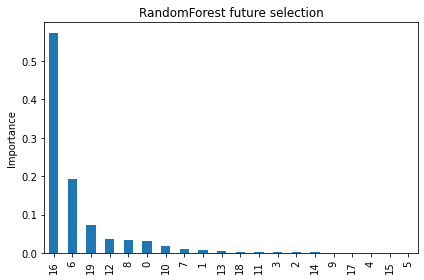

In [30]:
X = df.loc[:, df.columns != 'target']
Y = df['target']
rf=RandomForestRegressor(n_estimators=100)
rf.fit(X,Y)

imp = pd.Series(rf.feature_importances_)
imp.index = pd.Series(X.columns)
imp.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title("RandomForest future selection")
ax.set_ylabel("Importance")
fig.tight_layout()

Удалим параметры имеющие меньшее влияние на модель и вычислим точность

In [31]:
new_X = X.drop(X.iloc[:, [5,15,4,17,9,14,2,3,11,18,13,1,7,10,0,8,12]],axis = 1)
accuracy = cross_val_score(LogisticRegression(), new_X, Y, scoring='accuracy').mean()
print("Selected params by RandomForest accuracy:", accuracy)
accuracies["RandomForest"] = accuracy 

Selected params by RandomForest accuracy: 0.9299999999999999


Используем KNeighborsClassifier для подбора параметров

In [34]:
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3)
sfs.fit(X, Y)
SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                          n_features_to_select=3)
new_X = sfs.transform(X)
accuracy = cross_val_score(LogisticRegression(), new_X, Y, scoring='accuracy').mean()
print("Selected params by KNeighbors accuracy:", accuracy)
accuracies["KNeighbors"] = accuracy 

Selected params by KNeighbors accuracy: 0.9199999999999999


Выведем точности всех методов отбора параметров

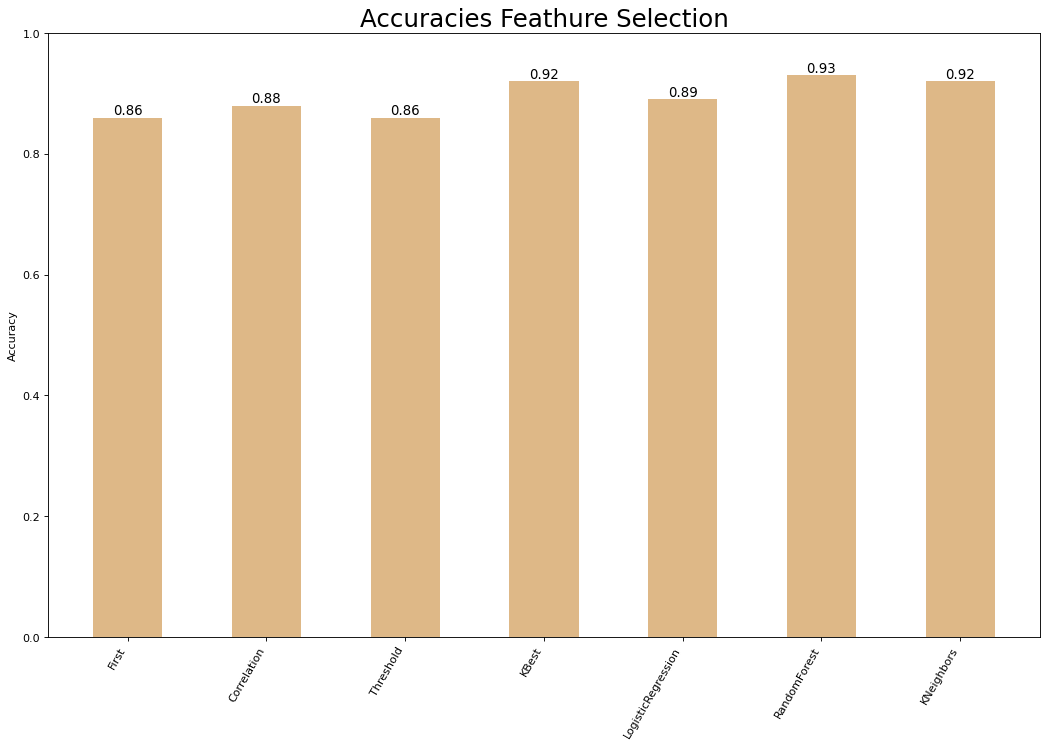

In [36]:
plt.figure(figsize=(16,10), dpi= 80)
plt.bar(accuracies.keys(), accuracies.values(), color='burlywood', width=.5)
for i, val in enumerate(accuracies.values()):
    plt.text(i, val, round(val,2), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})
plt.gca().set_xticklabels(accuracies.keys(), rotation=60, horizontalalignment= 'right')
plt.title("Accuracies Feathure Selection", fontsize=22)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Сбор точности моделей показал, что отбор лучших параметров может дать отличные результаты, прибавку к точности.